#### **함수 및 라이브러리**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def extract_representative_frames_with_motion(folder_path, threshold_ratio=1.0, return_frames=False):
    image_files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith(".jpg") or f.endswith(".png")
    ])
    image_paths = [os.path.join(folder_path, f) for f in image_files]
    frames = [cv2.imread(p) for p in image_paths]

    assert len(frames) == 18, f"Expected 18 frames, found {len(frames)}"

    flow_algo = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_FAST)

    motion_scores = []
    for i in range(1, len(frames)):
        prev_gray = cv2.cvtColor(frames[i-1], cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)

        flow = flow_algo.calc(prev_gray, curr_gray, None)
        mag = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
        motion_score = np.mean(mag)
        motion_scores.append(motion_score)

    motion_scores_arr = np.array(motion_scores)
    mean_score = motion_scores_arr.mean()
    threshold = mean_score * threshold_ratio

    rep_frame_indices = [i+1 for i, score in enumerate(motion_scores) if score >= threshold]

    if return_frames:
        rep_frames = [frames[i] for i in rep_frame_indices]
        rep_filenames = [image_files[i] for i in rep_frame_indices]
        return rep_frame_indices, motion_scores, rep_frames, rep_filenames
    else:
        return rep_frame_indices, motion_scores

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\ProgramData\Anaconda3\envs\TeamPossible\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

#### **비디오 프레임 간 이동량 기반 대표 이미지 및 캡션 추출 Demo**

프레임별 이동량: [2.2323225, 3.3216352, 4.114568, 3.2743, 2.4456964, 1.9335097, 1.8869717, 2.6235409, 2.4239194, 2.0921197, 1.668285, 2.035406, 2.4279819, 1.6073236, 0.9528889, 1.3518355, 41.205517]
대표 프레임 인덱스: [17]


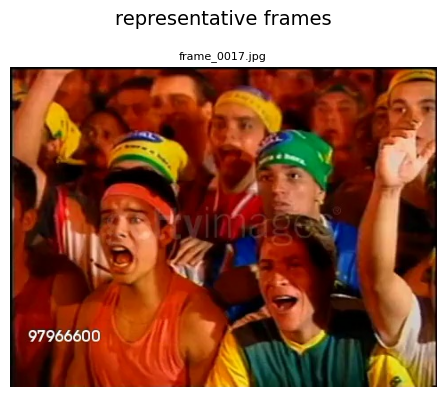

In [72]:
#folder = r"D:\RGB\training\barking\18frames\getty-barking-dog-with-alpha-channel-video-id507760354_6"
folder = r"D:\RGB\training\applauding\18frames\getty-21jun2002-montage-brazil-fans-watching-match-on-big-screen-in-town-video-id97966600_42"

rep_indices, motion_list, rep_frames, rep_filenames = extract_representative_frames_with_motion(
    folder, threshold_ratio=1.2, return_frames=True
)

print("프레임별 이동량:", motion_list)
print("대표 프레임 인덱스:", rep_indices)

plt.figure(figsize=(15, 4))
for idx, (img, fname) in enumerate(zip(rep_frames, rep_filenames)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(rep_frames), idx + 1)
    plt.imshow(img_rgb)
    plt.title(fname, fontsize=8)
    plt.axis("off")
plt.suptitle("representative frames", fontsize=14)
plt.tight_layout()
plt.show()


In [73]:
print("대표 프레임 캡션 결과:")
for idx, filename in enumerate(rep_filenames):
    image_path = os.path.join(folder, filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(image, return_tensors="pt").to(device)
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)

    print(f"[{filename}] : {caption}")


대표 프레임 캡션 결과:
[frame_0017.jpg] : a group of people in a crowd with their hands up


#### **비디오 캡션 - 라벨(528) 매핑**

In [74]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

audioset_df = pd.read_csv(r"C:\Users\swu\Downloads\Audioset_Label.csv")
labels = audioset_df['label'].tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
label_embeddings = model.encode(labels, convert_to_tensor=True)

def find_top_k_labels_for_caption(caption, top_k=3):
    caption_embedding = model.encode([caption], convert_to_tensor=True)
    similarities = cosine_similarity(caption_embedding.cpu(), label_embeddings.cpu())[0]
    top_indices = similarities.argsort()[::-1][:top_k]
    top_labels = [(labels[i], similarities[i]) for i in top_indices]
    return top_labels

In [ ]:
top_matches = find_top_k_labels_for_caption(caption)
print("캡션과 의미가 가장 유사한 오디오 라벨:")
for label, score in top_matches:
    print(f" - {label} (score: {score:.4f})")

캡션과 의미가 가장 유사한 오디오 라벨:
 - Crowd (score: 0.6810)
 - Hands (score: 0.4560)
 - Applause (score: 0.3050)
